In [ ]:
# PYTHON LIBRARIES
%matplotlib inline

import math
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.rc('xtick', labelsize=15)     
plt.rc('ytick', labelsize=15)
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

from matplotlib import cm
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
number = LabelEncoder()
from statsmodels.stats.outliers_influence import summary_table
from adjustText import adjust_text
from collections import OrderedDict

# Adjust css for usability
from IPython.core.display import HTML
HTML('''
<style type="text/css">

.jp-RenderedHTMLCommon table {
    table-layout: auto;
    border-collapse: collapse;
    width: 75%;
}

.jp-RenderedHTMLCommon table .absorbing-column {
    width: 75%;
}

</style>
''')

# CONSTANTS

markerSymbol = [
    "o", #circle
    "v", #triangle_down
    "^", #triangle_up
    "<", #triangle_left
    ">", #triangle_right
    "s", #square
    "p", #pentagon
    "P", #plus (filled)
    "*", #star
    "H", #hexagon2
    "X", #x (filled)
    "D", #diamond
    "d", #thin_diamond
    "1", #tri_down
    "2", #tri_up
    "3", #tri_left
    "4", #tri_right
    "+", #plus
    "x"  #x
];

markerColour = [
    '#b71c1c', #red darken-4
    '#1a237e', #indigo darken-4
    '#004d40', #teal darken-4
    '#f57f17', #yellow darken-4
    '#3e2723', #brown darken-4    
    '#4a148c', #purple darken-4
    '#01579b', #light-blue darken-4
    '#33691e', #light-green darken-4
    '#e65100', #orange darken-4
    '#263238', #blue-grey darken-4
    '#880e4f', #pink darken-4
    '#0d47a1', #blue darken-4
    '#1b5e20', #green darken-4
    '#ff6f00', #amber darken-4
    '#212121', #grey darken-4
    '#311b92', #deep-purple darken-4
    '#006064', #cyan darken-4
    '#827717', #lime darken-4
    '#bf360c'  #deep-orange darken-4
];

## Function to scatter plot

In [ ]:
# GET THE MAGNITUDE ORDER OF A NUMBER
def magnitude(value):
    if (value == 0): return 0
    return 10**(int(math.floor(math.log10(abs(value)))))

In [ ]:
# SIMPLE SCATTER PLOT OF TWO VARIABLES
def scatterPlot(x_str, x_units, y_str, y_units, df, fig_name):
    # PLOT FIG
    scale = 6;
    fig, ax = plt.subplots(figsize=(3*scale, 2*scale));

    # sort values by the independent variable
    df_x = df.sort_values(by=[x_str])
    # remove NANs from both variables and store them
    df_x = df_x.dropna(subset=[x_str, y_str])
    x = df_x.iloc[:][x_str]
    y = df_x.iloc[:][y_str]

    # Plot
    plt.scatter(x, y, s=25)
    
    # Display plots
    plt.yscale('linear');
    plt.xlabel(x_str + '    ' + x_units, fontsize=24);
    plt.ylabel(y_str + '    ' + y_units, fontsize=24);
    plt.title(fig_name, size=24);
    #plt.legend(prop={'size': 18});
    #plt.ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
    plt.show();

In [82]:
# SCATTER PLOT WITH AXIS-BREAK AND REFERENCE ANNOTATIONS
def scatterPlot_breakAxis(x_str, x_units, y_str, y_units, df, df_x, breakXlim=-1, breakYlim=-1, legloc='best'):
    ''' <required> x_str              : x-axis name. Must match a column name within df and df_x
    
        <required> x_units            : String used to print the x-axis units
        
        <required> y_str              : y-axis name. Must match a column name within df and df_x
        
        <required> y_units            : String used to print the y-axis units
        
        <required> df                 : raw dataframe structure obtained from reading a CSV file
        
        <required> df_x               : Same as df, but string values are replaced with some representative
                                        integer values
        
        <optional> breakXlim=-1       : only useful if breakOption!='none'
                                        Specify the no. of points to be plotted within the lower x-axis range
                                   
        <optional> breakYlim=-1       : only useful if breakOption!='none'
                                        Specify the no. of points to be plotted within the lower y-axis range
                                
        <optional> legloc='best'      : Specify the legend box location. It can be:
                                        |-------------------+---------------|
                                        | Location String   | Location Code |
                                        |-------------------+---------------|
                                        | 'best'            |  0            |
                                        | 'upper right'     |  1            |
                                        | 'upper left'      |  2            |
                                        | 'lower left'      |  3            |
                                        | 'lower right'     |  4            |
                                        | 'right'           |  5            |
                                        | 'center left'     |  6            |
                                        | 'center right'    |  7            |
                                        | 'lower center'    |  8            |
                                        | 'upper center'    |  9            |
                                        | 'center'          | 10            |
                                        |-------------------+---------------|'''
    
    # LET'S CHOOSE HOW TO BREAK THE PLOT
    
    if (breakXlim < 1 and breakYlim > 0): #only break the y-axis
        
        # GET THE X Y VALUES
        # sort values by the independent variable
        df_xx = df_x.sort_values(by=[y_str])
        # remove NANs from both variables and store them
        df_xx = df_x.dropna(subset=[x_str, y_str])
        x = df_xx.iloc[:][x_str]
        y = df_xx.iloc[:][y_str]
        polymerColour = df_xx.iloc[:]['Polymer']

        # GET THE REFERENCE STRING VALUES FOR PLOT ANNOTATIONS
        ref = df.iloc[:]['Reference']
        polymerName = df.iloc[:]['Polymer']

        # CREATE A NEW DATAFRAME WITH THE INTERESTING DATA ONLY
        # IN ORDER TO EFFECTIVELY REMOVE DUPLICATES
        new_df = pd.DataFrame(x)
        new_df = new_df.join(pd.DataFrame(y))
        new_df = new_df.join(pd.DataFrame(ref))
        new_df = new_df.join(pd.DataFrame(polymerColour))
        new_df = new_df.join(pd.DataFrame(polymerName).rename(columns={"Polymer": "Polymer Name"}))

        # Drop duplicate values 
        new_df = new_df.drop_duplicates(subset=new_df.columns.difference(['Polymer', 'Polymer Name']))
        # sort values by the independent variable
        new_df = new_df.sort_values(by=[y_str])

        # Extract the interesting data frame into individual
        # panda series
        x   = new_df.iloc[:][x_str]
        y   = new_df.iloc[:][y_str]
        ref = new_df.iloc[:]['Reference']
        polColour = new_df.iloc[:]['Polymer']    
        polName = new_df.iloc[:]['Polymer Name']

        # PLOT SETUP
        scale = 6;
        fig = plt.figure(figsize=(3*scale, 2*scale))
        
        # Implement a 3rows-1column grid to plot an "axis break"
        # SMALL TOP - BIG BOTTOM
        grid = plt.GridSpec(3, 1, wspace=0.4)
        ax0 = fig.add_subplot(grid[0, 0]);  # TOP part
        ax1 = fig.add_subplot(grid[1:, 0]); # BOTTOM part
        '''
        # EQUAL SIZE TOP AND BOTTOM
        grid = plt.GridSpec(2, 1, wspace=0.4)
        ax0 = fig.add_subplot(grid[0, 0]);  # TOP part
        ax1 = fig.add_subplot(grid[1, 0]); # BOTTOM part
        '''
        '''
        # BIG TOP - SMALL BOTTOM
        grid = plt.GridSpec(3, 1, wspace=0.4)
        ax0 = fig.add_subplot(grid[:2, 0]);  # TOP part
        ax1 = fig.add_subplot(grid[2, 0]); # BOTTOM part
        '''

        # Use breakYlim to split the data and plot accordingly on each subplot
        # Plot each point individually to give each a defined color according to its related polymer
        for xi, yi, ci, ni in zip(x[breakYlim:], y[breakYlim:], polColour[breakYlim:], polName[breakYlim:]):
            ax0.scatter(xi, yi, s=75, label=ni, c=markerColour[ci], marker=markerSymbol[ci]);
        for xi, yi, ci, ni in zip(x[:breakYlim], y[:breakYlim], polColour[:breakYlim], polName[:breakYlim]):
            ax1.scatter(xi, yi, s=75, label=ni, c=markerColour[ci], marker=markerSymbol[ci]);

        # ZOOM-IN AND LIMIT THE VIEW TO DIFFERENT PORTIONS OF THE DATA
        dy_top = magnitude(max(y)-y.values[breakYlim])/10
        dy_bot = magnitude(y.values[breakYlim]-min(y))/10
        dx = magnitude(max(x)-min(x))/2.5

        # same x-axis limits for all subplots to be consistent with scaling
        ax0.set_xlim(min(x)-dx, max(x)+dx)
        ax1.set_xlim(min(x)-dx, max(x)+dx)

        # y-limits for the TOP part
        ax0.set_ylim(y.values[breakYlim]-dy_top, max(y)+dy_top)

        # y-limits for the BOTTOM part
        ax1.set_ylim(min(y)-dy_bot, y.values[breakYlim-1]+dy_bot)

        # hide the spines and axis between ax0 and ax1
        ax0.spines['bottom'].set_visible(False) # hide bottom border
        ax0.axes.get_xaxis().set_visible(False) # hide xaxis labels
        ax1.spines['top'].set_visible(False)
        ax1.xaxis.tick_bottom()

        ax0.yaxis.get_major_ticks()[1].label1.set_visible(False)

        # FORMAT THE AXIS BREAK GRAPHICS
        d = .0075; # how big to make the diagonal lines in axes coordinates
        d0 = d*2;  # add some offset to have the same inclination on all diagonals
        # arguments to pass to plot, just so we don't keep repeating them
        kwargs = dict(transform=ax0.transAxes, color='k', clip_on=False)
        # draw top-left diagonal
        ax0.plot((0-d, 0+d), (0-d0, 0+d0), **kwargs)
        # draw top-right diagonal
        ax0.plot((1-d, 1+d), (0-d0, 0+d0), **kwargs)
        kwargs.update(transform=ax1.transAxes)  # switch to the bottom axes
        # draw bottom-left diagonal
        ax1.plot((0-d, 0+d), (1-d, 1+d), **kwargs)
        # draw bottom-right diagonal
        ax1.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

        # Vary the distance between ax0 and ax1
        fig.subplots_adjust(hspace=0.1)

        # GROUP ALL SUBPLOTS TO ADD FURTHER FORMATTING
        # add a big axis to group all, and hide its frame
        main = fig.add_subplot(111, frameon=False)
        # hide tick and tick label of the big axis
        plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

        # Display plots
        plt.xlabel(x_str + '    ' + x_units, fontsize=24);
        ax0.set_ylabel(y_str + '    ' + y_units, fontsize=24)
        ax0.yaxis.set_label_coords(-0.06, 0)
        #plt.title(fig_name, size=24);
        # add annotations (references on each point)
        texts_ax0 = []
        for xs, ys, ss in zip(x[breakYlim:], y[breakYlim:], ref[breakYlim:]):
            texts_ax0.append(ax0.text(xs, ys, str(ss), fontsize=15))
        texts_ax1 = []
        for xs, ys, ss in zip(x[:breakYlim], y[:breakYlim], ref[:breakYlim]):
            texts_ax1.append(ax1.text(xs, ys, str(ss), fontsize=15))
        # avoid overlaps between annotations and add a linking line
        kwargs = dict(transform=ax0.transAxes)
        adjust_text(texts_ax0, ax=ax0, arrowprops=dict(arrowstyle="-", color='k', lw=0.5), save_steps=False, **kwargs)
        kwargs = dict(transform=ax1.transAxes)
        adjust_text(texts_ax1, ax=ax1, arrowprops=dict(arrowstyle="-", color='k', lw=0.5), save_steps=False, **kwargs)

        # Show the plot lengend to link colors and polymer names
        handles0, labels0 = ax0.get_legend_handles_labels()
        handles1, labels1 = ax1.get_legend_handles_labels()
        lgd = dict(zip(labels0+labels1, handles0+handles1))
    
    elif (breakXlim > 0 and breakYlim < 1): #only break the x-axis
        
        # GET THE X Y VALUES
        # sort values by the independent variable
        df_xx = df_x.sort_values(by=[x_str])
        # remove NANs from both variables and store them
        df_xx = df_x.dropna(subset=[x_str, y_str])
        x = df_xx.iloc[:][x_str]
        y = df_xx.iloc[:][y_str]
        polymerColour = df_xx.iloc[:]['Polymer']

        # GET THE REFERENCE STRING VALUES FOR PLOT ANNOTATIONS
        ref = df.iloc[:]['Reference']
        polymerName = df.iloc[:]['Polymer']

        # CREATE A NEW DATAFRAME WITH THE INTERESTING DATA ONLY
        # IN ORDER TO EFFECTIVELY REMOVE DUPLICATES
        new_df = pd.DataFrame(x)
        new_df = new_df.join(pd.DataFrame(y))
        new_df = new_df.join(pd.DataFrame(ref))
        new_df = new_df.join(pd.DataFrame(polymerColour))
        new_df = new_df.join(pd.DataFrame(polymerName).rename(columns={"Polymer": "Polymer Name"}))

        # Drop duplicate values 
        new_df = new_df.drop_duplicates(subset=new_df.columns.difference(['Polymer', 'Polymer Name']))
        # sort values by the independent variable
        new_df = new_df.sort_values(by=[x_str])

        # Extract the interesting data frame into individual
        # panda series
        x   = new_df.iloc[:][x_str]
        y   = new_df.iloc[:][y_str]
        ref = new_df.iloc[:]['Reference']
        polColour = new_df.iloc[:]['Polymer']    
        polName = new_df.iloc[:]['Polymer Name']

        # PLOT SETUP
        scale = 6;
        fig = plt.figure(figsize=(3*scale, 2*scale))
        
        # Implement a 1row-3columns grid to plot an "axis break"
        # SMALL TOP - BIG BOTTOM
        grid = plt.GridSpec(1, 3, wspace=0.4)
        ax0 = fig.add_subplot(grid[0, :-1]); # LEFT part
        ax1 = fig.add_subplot(grid[0, -1]);  # RIGHT part

        # Use breakYlim to split the data and plot accordingly on each subplot
        # Plot each point individually to give each a defined color according to its related polymer
        for xi, yi, ci, ni in zip(x[breakXlim:], y[breakXlim:], polColour[breakXlim:], polName[breakXlim:]):
            ax1.scatter(xi, yi, s=75, label=ni, c=markerColour[ci], marker=markerSymbol[ci]);
        for xi, yi, ci, ni in zip(x[:breakXlim], y[:breakXlim], polColour[:breakXlim], polName[:breakXlim]):
            ax0.scatter(xi, yi, s=75, label=ni, c=markerColour[ci], marker=markerSymbol[ci]);
        
        # ZOOM-IN AND LIMIT THE VIEW TO DIFFERENT PORTIONS OF THE DATA
        dx_top = magnitude(max(x)-x.values[breakXlim])/10
        dx_bot = magnitude(x.values[breakXlim]-min(x))/10
        dy = magnitude(max(y)-min(y))/10
        
        # same x-axis limits for all subplots to be consistent with scaling
        ax1.set_ylim(min(y)-dy, max(y)+dy)
        ax0.set_ylim(min(y)-dy, max(y)+dy)

#         # y-limits for the TOP part
#         ax0.set_ylim(y.values[breakYlim]-dy_top, max(y)+dy_top)

#         # y-limits for the BOTTOM part
#         ax1.set_ylim(min(y)-dy_bot, y.values[breakYlim-1]+dy_bot)

#         # hide the spines and axis between ax0 and ax1
#         ax0.spines['bottom'].set_visible(False) # hide bottom border
#         ax0.axes.get_xaxis().set_visible(False) # hide xaxis labels
#         ax1.spines['top'].set_visible(False)
#         ax1.xaxis.tick_bottom()

#         ax0.yaxis.get_major_ticks()[1].label1.set_visible(False)

#         # FORMAT THE AXIS BREAK GRAPHICS
#         d = .0075; # how big to make the diagonal lines in axes coordinates
#         d0 = d*2;  # add some offset to have the same inclination on all diagonals
#         # arguments to pass to plot, just so we don't keep repeating them
#         kwargs = dict(transform=ax0.transAxes, color='k', clip_on=False)
#         # draw top-left diagonal
#         ax0.plot((0-d, 0+d), (0-d0, 0+d0), **kwargs)
#         # draw top-right diagonal
#         ax0.plot((1-d, 1+d), (0-d0, 0+d0), **kwargs)
#         kwargs.update(transform=ax1.transAxes)  # switch to the bottom axes
#         # draw bottom-left diagonal
#         ax1.plot((0-d, 0+d), (1-d, 1+d), **kwargs)
#         # draw bottom-right diagonal
#         ax1.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

#         # Vary the distance between ax0 and ax1
#         fig.subplots_adjust(hspace=0.1)

#         # GROUP ALL SUBPLOTS TO ADD FURTHER FORMATTING
#         # add a big axis to group all, and hide its frame
#         main = fig.add_subplot(111, frameon=False)
#         # hide tick and tick label of the big axis
#         plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

#         # Display plots
#         plt.xlabel(x_str + '    ' + x_units, fontsize=24);
#         ax0.set_ylabel(y_str + '    ' + y_units, fontsize=24)
#         ax0.yaxis.set_label_coords(-0.06, 0)
#         #plt.title(fig_name, size=24);
#         # add annotations (references on each point)
#         texts_ax0 = []
#         for xs, ys, ss in zip(x[breakYlim:], y[breakYlim:], ref[breakYlim:]):
#             texts_ax0.append(ax0.text(xs, ys, str(ss), fontsize=15))
#         texts_ax1 = []
#         for xs, ys, ss in zip(x[:breakYlim], y[:breakYlim], ref[:breakYlim]):
#             texts_ax1.append(ax1.text(xs, ys, str(ss), fontsize=15))
#         # avoid overlaps between annotations and add a linking line
#         kwargs = dict(transform=ax0.transAxes)
#         adjust_text(texts_ax0, ax=ax0, arrowprops=dict(arrowstyle="-", color='k', lw=0.5), save_steps=False, **kwargs)
#         kwargs = dict(transform=ax1.transAxes)
#         adjust_text(texts_ax1, ax=ax1, arrowprops=dict(arrowstyle="-", color='k', lw=0.5), save_steps=False, **kwargs)

#         # Show the plot lengend to link colors and polymer names
#         handles0, labels0 = ax0.get_legend_handles_labels()
#         handles1, labels1 = ax1.get_legend_handles_labels()
#         lgd = dict(zip(labels0+labels1, handles0+handles1))
    
    elif (breakXlim > 0 and breakYlim > 0): #break both axes
    
        print('TODO: break both axes')
    
    else: #do not break any axes
        
        print('TODO: do not break any axes')
    
    # Display main plot
    main.legend(lgd.values(), lgd.keys(), prop={'size': 15}, loc=legloc)
    plt.show()
    
    # Print the interesting data
    #print('>>> new_df')
    #display(new_df)

# NFESdata.csv description:

<table align="center">
    <tr>
        <th><b>Parameter_Name</b></th>
        <th><b>Parameter_Units</b></th>
        <th><b>Data_Type</b></th>
        <th class="absorbing-column"><b>Description</b></th>
    </tr>
    <tr>
        <td><b>Polymer</b></td>
        <td>$N/A$</td>
        <td>string</td>
        <td>polymer used in the NFES solution</td>
    </tr>
    <tr>
        <td><b>Polymer Molecular Weight</b></td>
        <td>$g \cdot {mol}^{-1}$</td>
        <td>float</td>
        <td>polymer molecular weight</td>
    </tr>
    <tr>
        <td><b>Solvent</b></td>
        <td>$N/A$</td>
        <td>string</td>
        <td>solvent used in the NFES solution</td>
    </tr>
    <tr>
        <td><b>Solvent Surface Tension</b></td>
        <td>$mN \cdot m^{-1}$</td>
        <td>float</td>
        <td>solvent surface tension at $298.2 K$ and $101325 Pa$</td>
    </tr>
    <tr>
        <td><b>Solvent Dielectric Constant</b></td>
        <td>$N/A$</td>
        <td>float</td>
        <td>solvent dielectric constant at $298.2 K$</td>
    </tr>
    <tr>
        <td><b>Solvent Boiling Point</b></td>
        <td>$^{\circ} C$</td>
        <td>float</td>
        <td>solvent boiling point</td>
    </tr>
    <tr>
        <td><b>Solvent Density</b></td>
        <td>$g \cdot ml^{-1}$</td>
        <td>float</td>
        <td>solvent relative density (water = 1) at $293.15 K$</td>
    </tr>
    <tr>
        <td><b>Solvent Vapour Pressure</b></td>
        <td>$kPa$</td>
        <td>float</td>
        <td>solvent vapour pressure at $293.15 K$</td>
    </tr>
    <tr>
        <td><b>NFES Type</b></td>
        <td>$N/A$</td>
        <td>string</td>
        <td>NFES process type/variant implemented in [reference]</td>
    </tr>
    <tr>
        <td><b>Polymer Concentration</b></td>
        <td>$wt\%$</td>
        <td>float</td>
        <td>polymer concentration used in the NFES solution</td>
    </tr>
    <tr>
        <td><b>Nozzle Diameter</b></td>
        <td>$\mu m$</td>
        <td>float</td>
        <td>inner diameter of the dispensing nozzle</td>
    </tr>
    <tr>
        <td><b>Solution Deposition Rate</b></td>
        <td>$\mu L \cdot h^{-1}$</td>
        <td>float</td>
        <td>rate at which the solution is dispensed from the reservoir</td>
    </tr>
    <tr>
        <td><b>Collector Substrate</b></td>
        <td>$N/A$</td>
        <td>string</td>
        <td>composition of the collector</td>
    </tr>
    <tr>
        <td><b>Nozzle to Collector Distance</b></td>
        <td>$mm$</td>
        <td>float</td>
        <td>distance between the dispensing nozzle and the collector</td>
    </tr>
    <tr>
        <td><b>NFES Applied Voltage</b></td>
        <td>$V$</td>
        <td>float</td>
        <td>applied voltage between the dispensing nozzle and the collector during NFES</td>
    </tr>
    <tr>
        <td><b>NFES Stage Velocity</b></td>
        <td>$mm \cdot s^{-1}$</td>
        <td>float</td>
        <td>velocity at which the stage/collector moves with respect to the dispensing nozzle</td>
    </tr>
    <tr>
        <td><b>Fiber Diameter</b></td>
        <td>$nm$</td>
        <td>float</td>
        <td>diameter of the produced fibers</td>
    </tr>
    <tr>
        <td><b>Distance Between Fibers</b></td>
        <td>$\mu m$</td>
        <td>float</td>
        <td>minimum distance achieved between two parallel fibers</td>
    </tr>
    <tr>
        <td><b>Reference</b></td>
        <td>$N/A$</td>
        <td>string</td>
        <td>reference author name and publication year</td>
    </tr>
</table>

## Give strings a numeric value

In [ ]:
df = pd.read_csv("./NFESdata.csv", delimiter=",");

# df.loc[<ROWS RANGE> , <COLUMNS RANGE>] to get elements by index

# Assign a numeric value to string data type values
df_x = df.copy();
for col in range(len(df.columns)):
    if str(type(df.iloc[0 , col])) == "<class 'str'>":
        df_x.iloc[: , col] = number.fit_transform(df.iloc[: , col].astype('str'))

## Print column name and its data type
#print()
#for col in range(len(df.columns)):
#    print(str(df.columns[col]) + ' ' + str(type(df.iloc[0 , col])))

display(df.head());
display(df_x.head());

# Correlation Matrix

In [ ]:
scale = 12;
corrMatrix = df_x.drop(["Solvent Surface Tension", "Solvent Dielectric Constant", "Solvent Boiling Point", "Solvent Density", "Solvent Vapour Pressure", "Reference"], axis=1).corr()
pd.plotting.scatter_matrix(corrMatrix, alpha=0.5, figsize=(3*scale, 2*scale), s=scale*10)
plt.show()
display(corrMatrix.style.background_gradient(cmap='viridis'))

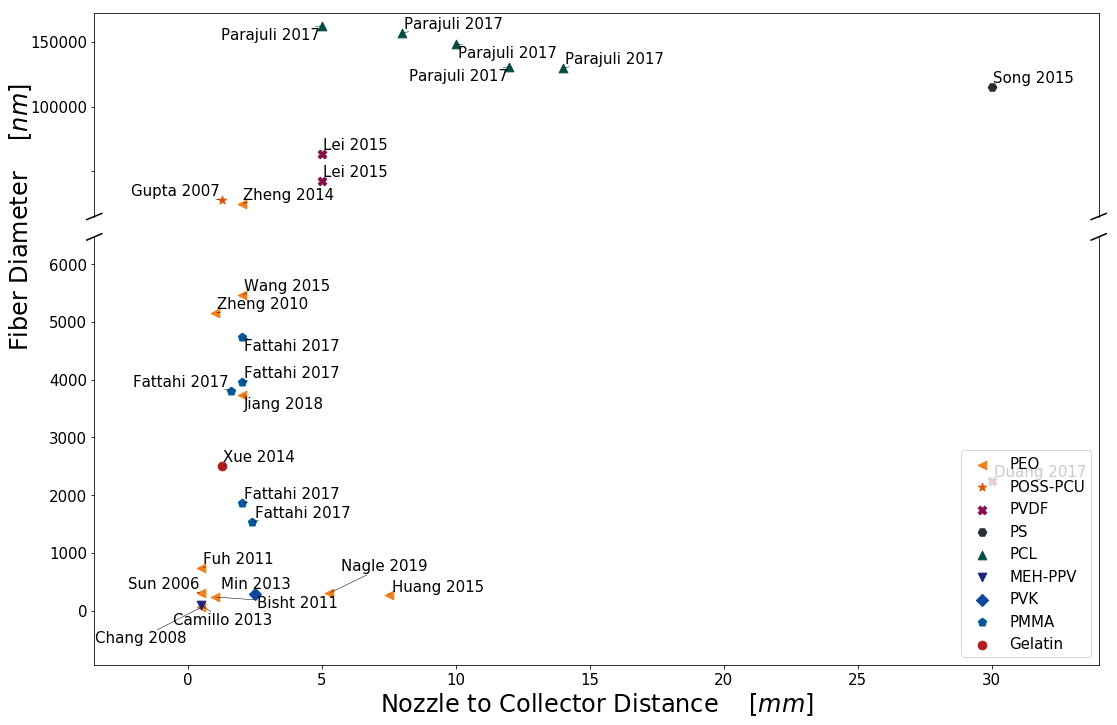

UnboundLocalError: local variable 'main' referenced before assignment

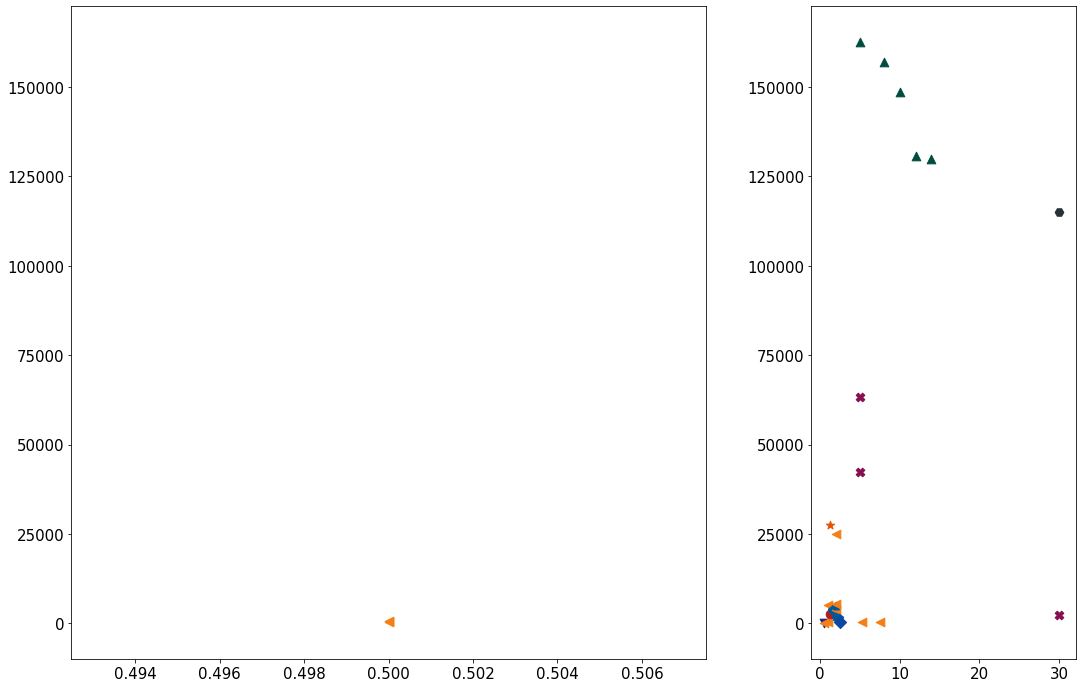

In [85]:
# PLOT FIGs
x_str = [];
x_units = [];
y_str = [];
y_units = [];
breakXlim = [];
breakYlim = [];

x_str.append('Nozzle to Collector Distance'); x_units.append(r'$[mm]$');
y_str.append('Fiber Diameter'); y_units.append(r'$[nm]$');
breakXlim.append(0);
breakYlim.append(18);

x_str.append('Nozzle to Collector Distance'); x_units.append(r'$[mm]$');
y_str.append('Fiber Diameter'); y_units.append(r'$[nm]$');
breakXlim.append(26);
breakYlim.append(0);

########################################

# x_str.append('Nozzle Diameter'); x_units.append(r'$[\mu m]$');
# y_str.append('Solution Deposition Rate'); y_units.append(r'$[\mu L \cdot h^{-1}]$');
# breakXlim.append(0);
# breakYlim.append(3);

# x_str.append('Nozzle Diameter'); x_units.append(r'$[\mu m]$');
# y_str.append('NFES Applied Voltage'); y_units.append(r'$[V]$');
# breakXlim.append(0);
# breakYlim.append(16);

# x_str.append('Polymer Concentration'); x_units.append(r'$[wt\%]$');
# y_str.append('NFES Applied Voltage'); y_units.append(r'$[V]$');
# breakXlim.append(0);
# breakYlim.append(27);

# x_str.append('Solution Deposition Rate'); x_units.append(r'$[\mu L \cdot h^{-1}]$');
# y_str.append('Distance Between Fibers'); y_units.append(r'$[\mu m]$');
# breakXlim.append(0);
# breakYlim.append(7);

# x_str.append('NFES Stage Velocity'); x_units.append(r'$[mm \cdot s^{-1}]$');
# y_str.append('Distance Between Fibers'); y_units.append(r'$[\mu m]$');
# breakXlim.append(0);
# breakYlim.append(11);

# x_str.append('Solution Deposition Rate'); x_units.append(r'$[\mu L \cdot h^{-1}]$');
# y_str.append('Fiber Diameter'); y_units.append(r'$[nm]$');
# breakXlim.append(0);
# breakYlim.append(11);

# x_str.append('NFES Stage Velocity'); x_units.append(r'$[mm \cdot s^{-1}]$');
# y_str.append('Fiber Diameter'); y_units.append(r'$[nm]$');
# breakXlim.append(0);
# breakYlim.append(16);

# x_str.append('NFES Applied Voltage'); x_units.append(r'$[V]$');
# y_str.append('Fiber Diameter'); y_units.append(r'$[nm]$');
# breakXlim.append(0);
# breakYlim.append(18);

# x_str.append('Nozzle to Collector Distance'); x_units.append(r'$[mm]$');
# y_str.append('Fiber Diameter'); y_units.append(r'$[nm]$');
# breakXlim.append(0);
# breakYlim.append(18);

# x_str.append('Polymer Concentration'); x_units.append(r'$[wt\%]$');
# y_str.append('Fiber Diameter'); y_units.append(r'$[nm]$');
# breakXlim.append(0);
# breakYlim.append(18);

########################################

for i in range(len(x_str)):
    #scatterPlot(x_str[i], x_units[i], y_str[i], y_units[i], df[i], 'original')
    scatterPlot_breakAxis(x_str[i], x_units[i], y_str[i], y_units[i], df, df_x, breakXlim[i], breakYlim[i], 'lower right');

In [ ]:
# import pdfkit
# path_wkthmltopdf = r'C:\Program Files\wkhtmltopdf\bin\wkhtmltopdf.exe'
# config = pdfkit.configuration(wkhtmltopdf=path_wkthmltopdf)

# options = {
#     'page-size': 'A4',
#     'margin-top': '0.0in',
#     'margin-right': '0.0in',
#     'margin-bottom': '0.0in',
#     'margin-left': '0.0in',
#     'encoding': "UTF-8",
#     'custom-header' : [
#         ('Accept-Encoding', 'gzip')
#     ],
#     'cookie': [
#         ('cookie-name1', 'cookie-value1'),
#         ('cookie-name2', 'cookie-value2'),
#     ],
#     'no-outline': None,
#     'orientation': 'Landscape'
# }

# pdfkit.from_file('./NFES_ReviewPaper.html','NFES_ReviewPaper.pdf', configuration=config, options=options)